# Import

In [1]:
import numpy as np
import tensorflow as tf
# next line only for Colab
%tensorflow_version 2.x
# import tensorflow-datasets to be able to access the tensorflow inbuilt datasets
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 1. Dataset

In [2]:
# Loading the inbuilt genomics_ood dataset 
# It contains genomic sequences that are 250 characters in length. 
# Each charater can be one of four different nucleotides (A, G, C, T)
# Our goal is to classify each genome sequence to one out of ten bacteria populations

# load the first 100000 tupels from the train data (sequence, label) 
# and the first 1000 tupels from the test data
train_data, test_data = tfds.load("genomics_ood", split=['train[:100000]', 'test[:1000]'], as_supervised=True)

In [3]:
# One-encode the nucleotides from our genomic sequences 
def onehotify(input):
    """Replaces the string sequence of nucleotides with a onehot encoding 
    Each nucleotide is replaced by a 4 digit onehot representation

    Arguments:
      input (bytes): String byte containing the nucleotide sequence of a bacteria
    
    Returns:
      onehot (EagerTensor): flattened onehot encoded nucleotide sequence 
    """
    # Dictionary to replace the nucleotides by numbers such that we can input the sequences in the one_hot function
    vocab = {'A':'0', 'C':'1', 'G':'2', 'T':'3'} 
    
    # replace each character with the respective number (still a string)
    for key in vocab.keys():
        input = tf.strings.regex_replace(input, key, vocab[key])

    # split the sequence of already replaced nucleotides into separate bytes
    # one byte per number
    split = tf.strings.bytes_split(input)

    # cast the string number into a uint8 number 
    labels = tf.cast(tf.strings.to_number(split), tf.uint8) 

    # onehot encode each number with 4 digits
    onehot = tf.one_hot(labels, 4)

    # flatten the output for the network 
    onehot = tf.reshape(onehot, (-1,)) 

    return onehot

In [4]:
onehotify?

# Added Comment
## Alternative Data Pipeline

```
train_dataset = train_data.map(lambda seq, lbl : (onehotify(seq), tf.one_hot(lbl, 10)))
train_dataset = train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(100).prefetch(10)

test_dataset = test_data.map(lambda seq, lbl : (onehotify(seq), tf.one_hot(lbl, 10)))
test_dataset = test_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(100).prefetch(10)
```

## Input Pipeline


In [5]:
# Added Comment
## We specifically chose the pipeline below where we load the data into the RAM, as it significantly decreased training time 

# for each data tupel we extract the sequence / label and save them in a dedicated list, while simultaneously onehotifying the sequences 
seq_train = [onehotify(seq) for seq,_ in train_data]
label_train = [label for _,label in train_data]
seq_test = [onehotify(seq) for seq,_ in test_data]
label_test = [label for _,label in test_data]

In [6]:
# create a tensorflow Dataset from the training nucleotid sequences and their labels respectively
train_dataset_seq = tf.data.Dataset.from_tensor_slices(seq_train)
train_dataset_labels = tf.data.Dataset.from_tensor_slices(label_train)
# onehot encode the target label using 10 digits representing the 10 different bacteria 
train_dataset_labels = train_dataset_labels.map(lambda t : tf.one_hot(t, 10))

# zip together the freshly created Datasets ((input, label) pairs)
train_dataset = tf.data.Dataset.zip((train_dataset_seq, train_dataset_labels))

# shuffle the batches 
train_dataset = train_dataset.shuffle(buffer_size=1000)

# create batches of 100 samples 
train_dataset = train_dataset.batch(100)

# When the GPU is working on forward / backward propagation on the current batch, we want the CPU to process the next batch of data so that it is immediately ready. 
# This way we ensure that the GPU is fully used all the time during training.
train_dataset = train_dataset.prefetch(10)


# repeat for test data set 
test_dataset_seq = tf.data.Dataset.from_tensor_slices(seq_test)
test_dataset_labels = tf.data.Dataset.from_tensor_slices(label_test)
test_dataset_labels = test_dataset_labels.map(lambda t : tf.one_hot(t, 10))

test_dataset = tf.data.Dataset.zip((test_dataset_seq, test_dataset_labels))

test_dataset = test_dataset.shuffle(buffer_size=1000)
test_dataset = test_dataset.batch(100)
test_dataset = test_dataset.prefetch(10)

# 2. Model

In [7]:
# We will implement a simple fully connected feed forward neural network like the last time.
#
# Our network will have the following layers:
# Input : 1000 units.
# Hidden layer 1: 256 units. With sigmoid activation function.
# Hidden layer 2: 256 units. With sigmoid activation function.
# Output: 10 units. With softmax activation function.

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    """Class for creating a MLP which inherits from the Model class from keras 
    """

    def __init__(self):
      """Initialize a MLP with a variable amount of keras.Layers
      """
      # use the keyword super to allow our MLP to access the init() form the keras Model class
      super(Model, self).__init__()

      # Define the layers structure.
      self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
      self.hidden_layer_2 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
      self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
        
    # use the decorator @tf.function to speed up the model call    
    @tf.function    
    def call(self, x):
      """Activate our MLP propagating the input through the network layer by layer

      Arguments:
        x (Tensor): Tensor containing the input to our MLP

      Returns:
        x (Tensor): Tensor containing the probabilities for the ten classes
      """
      x = self.hidden_layer_1(x)
      x = self.hidden_layer_2(x)
      x = self.output_layer(x)
      return x

# 3. Training

In [8]:
def train_step(model, input, target, loss_function, optimizer):
  """Perform a training step for a given Neural Network by
  1. Propagating the input through the network
  2. Calculating the loss between the networks output and the true targets 
  2. Performing Backpropagation and Updating the trainable variables witht the calculated gradients 

  Arguments:
    model (Model): given instance of an initialised Neural Network with all its parameters
    input (EagerTensor): Tensor containing the input data 
    target (EagerTensor): Tensor containing the respective targets 
    loss_function (keras.losses): function from keras to calculate the loss
    optimizer (keras.optimizers): function from keras defining the to be applied optimizer during learning 

  Returns:
    loss (EagerTensor): Tensor containing the loss of the Network 
  """
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    # 1.
    prediction = model(input)
    # 2.
    loss = loss_function(target, prediction)
    # 3.
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss 

def test(model, test_data, loss_function):
  """Tests the models accuracy and loss over the given data set with a given loss_function

  Arguments:
    model (Model): given instance of an initialised Neural Network with all its parameters
    test_data (Dataset): test dataset to test the NN on 
    loss_function (keras.losses): function from keras to calculate the loss 

  Returns:
    test_loss (float): Average loss of the Neural Network over the test set
    test_accuracy (float): Average accuray of the Neural Network over the test set
  """
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []
  
  for (input, target) in test_data:
    prediction = model(input)
    
    # calculates the loss value (as a tensors) for a entire batch 
    sample_test_loss = loss_function(target, prediction)

    # creates a boolean array of dimension (100,) for each batch 
    # each entry represents whether one (sequence, label) pair was predicted correctly 
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)

    # take the mean over each boolean array to obtain the average accuracy for one batch 
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())

    # append the mean of all batch accuracies  
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy


In [9]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters.
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

# testing once before we begin on the test data
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=100)
    test_dataset = test_dataset.shuffle(buffer_size=100)

    # training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    # testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    _, train_accuracy = test(model, train_dataset, cross_entropy_loss)
    train_accuracies.append(train_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


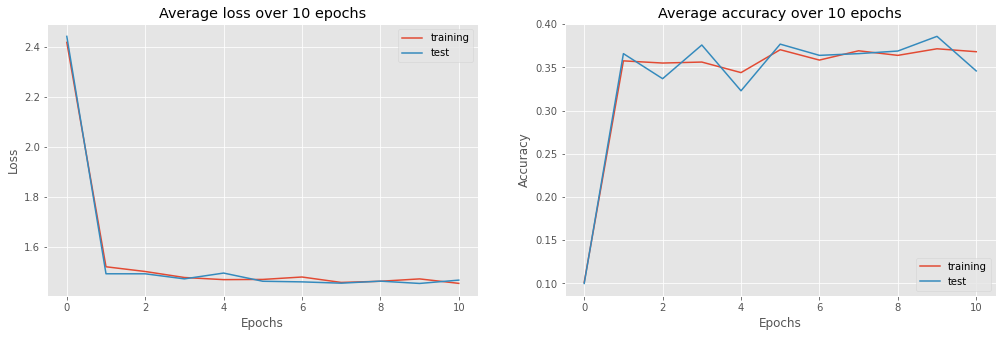

In [10]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.

# change the style of the plots to a nicer theme
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(17)

# plot for average loss
ax[0].plot(train_losses, label='training')
ax[0].plot(test_losses, label='test')
ax[0].set(ylabel='Loss', xlabel='Epochs', title='Average loss over 10 epochs')
ax[0].legend()

# plot for average accuracy 
ax[1].plot(train_accuracies, label='training')
ax[1].plot(test_accuracies, label='test')
ax[1].set(ylabel='Accuracy', xlabel='Epochs', title='Average accuracy over 10 epochs')
ax[1].legend()